In [1]:
import csv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import networkx.algorithms.community as nx_comm
from cdlib import evaluation, algorithms
from cdlib import NodeClustering
import pandas as pd
import community
from cdlib import algorithms
import matplotlib
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from collections import Counter
from statistics import mean

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'graph_tool', 'karateclub', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [2]:
#reads the csv
stocks = pd.read_csv('Prices2020.csv')
#craetes a correlation matrix
cor_matrix = stocks.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix.head()

,AFIN,AINM,ALLI,AMMB,ANCR,APES,BIMB,BMYS,CIMB,ECMI,...,MBSS,MNLF,MNRB,MPHB,PACO,PUBM,REDI,RHBC,TAKA,TUNE
AFIN,1.000000,0.802911,0.681030,0.896912,0.790813,-0.054143,0.833261,-0.219645,0.926784,0.441603,...,0.889804,0.723528,0.486619,0.637713,0.605383,0.810949,0.174527,0.924906,0.424330,0.843688
AINM,0.802911,1.000000,0.586331,0.791696,0.771348,-0.127222,0.746589,-0.210174,0.775269,0.252971,...,0.828458,0.738738,0.569905,0.587646,0.536179,0.609780,0.078047,0.715148,0.630735,0.819280
ALLI,0.681030,0.586331,1.000000,0.669214,0.644281,0.288668,0.866843,0.287916,0.535747,0.234489,...,0.455871,0.466836,0.719610,0.857000,0.368249,0.862662,0.727435,0.639518,0.638924,0.666909
AMMB,0.896912,0.791696,0.669214,1.000000,0.929379,-0.197024,0.831174,-0.353848,0.954524,0.538008,...,0.865181,0.802989,0.631609,0.712362,0.810904,0.755877,0.088703,0.918251,0.421130,0.894356
ANCR,0.790813,0.771348,0.644281,0.929379,1.000000,-0.242417,0.777791,-0.335602,0.871543,0.516909,...,0.781054,0.781984,0.704918,0.774754,0.872190,0.659117,0.071615,0.838647,0.471976,0.867796


In [3]:
#extracts the indices from the correlation matrix, which are the stocks
stocks = cor_matrix.index.values

In [4]:
cor_matrix.to_csv('output.csv')

In [5]:
# Create an array to store the upper triangular part of the correlation matrix
upper_triangle = np.triu(cor_matrix, k=1)

# Find the indices (i, j) of the maximum and minimum values in the upper triangular part
max_idx = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
min_idx = np.unravel_index(np.argmin(upper_triangle), upper_triangle.shape)

# Get the maximum and minimum values
max_value = upper_triangle[max_idx]
min_value = upper_triangle[min_idx]

# Get the respective entry names (i, j)
max_entry = (max_idx[0], max_idx[1])
min_entry = (min_idx[0], min_idx[1])

# Print the results
print(f"Maximum correlation ({max_value}) is between entries {max_entry}")
print(f"Minimum correlation ({min_value}) is between entries {min_entry}")

Maximum correlation (0.9545240395205894) is between entries (3, 8)
Minimum correlation (-0.5398948192823244) is between entries (7, 24)


In [6]:
# convert matrix to list of edges and rename the columns
edges = cor_matrix.stack().reset_index()
edges.columns = ["asset_1", "asset_2", "correlation"]

# remove self correlations
edges = edges.loc[edges["asset_1"] != edges["asset_2"]].copy()

# show the first 5 rows of the edge list dataframe.
edges.head()


,asset_1,asset_2,correlation
1,AFIN,AINM,0.802911
2,AFIN,ALLI,0.681030
3,AFIN,AMMB,0.896912
4,AFIN,ANCR,0.790813
5,AFIN,APES,-0.054143


In [7]:
# create undirected graph with weights corresponding to the correlation magnitude
G0 = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# print out the graph info
# check number of nodes and degrees are as expected
# (all should have degree = 29, i.e. average degree = 29)
print(nx.info(G0))


Name: 
Type: Graph
Number of nodes: 30
Number of edges: 435
Average degree:  29.0000


In [8]:
# Define a range of thresholds to explore
thresholds = np.arange(0.01, 1.0, 0.01)

# Iterate through each threshold
for threshold in thresholds:
    # Create a copy of the original graph
    Gprime = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

    # Initialize an empty list to store edges to remove
    remove = []

    # Loop through edges and identify those below the threshold
    for asset_1, asset_2 in Gprime.edges():
        corr = Gprime[asset_1][asset_2]["correlation"]
        if abs(corr) < threshold:
            remove.append((asset_1, asset_2))

    # Remove edges below the threshold
    Gprime.remove_edges_from(remove)

    # Calculate the network density
    density = nx.density(Gprime)

    # Print the current threshold and corresponding density
    print(f"Threshold: {threshold:.4f}, Density: {density:.4f}")

    # Check if the density is close to the target
    if abs(density - 0.1) < 0.01:
        # Found the desired threshold, stop the loop
        break

# If the loop finishes without finding a suitable threshold, print a message
if abs(density - 0.1) >= 0.01:
    print("Could not find a threshold that results in a density close to 0.2.")


Threshold: 0.0100, Density: 0.9931
Threshold: 0.0200, Density: 0.9839
Threshold: 0.0300, Density: 0.9701
Threshold: 0.0400, Density: 0.9678
Threshold: 0.0500, Density: 0.9609
Threshold: 0.0600, Density: 0.9494
Threshold: 0.0700, Density: 0.9471
Threshold: 0.0800, Density: 0.9356
Threshold: 0.0900, Density: 0.9287
Threshold: 0.1000, Density: 0.9241
Threshold: 0.1100, Density: 0.9195
Threshold: 0.1200, Density: 0.9195
Threshold: 0.1300, Density: 0.9126
Threshold: 0.1400, Density: 0.9080
Threshold: 0.1500, Density: 0.9034
Threshold: 0.1600, Density: 0.8989
Threshold: 0.1700, Density: 0.8943
Threshold: 0.1800, Density: 0.8759
Threshold: 0.1900, Density: 0.8690
Threshold: 0.2000, Density: 0.8644
Threshold: 0.2100, Density: 0.8621
Threshold: 0.2200, Density: 0.8414
Threshold: 0.2300, Density: 0.8345
Threshold: 0.2400, Density: 0.8207
Threshold: 0.2500, Density: 0.8161
Threshold: 0.2600, Density: 0.8092
Threshold: 0.2700, Density: 0.8046
Threshold: 0.2800, Density: 0.7954
Threshold: 0.2900, D

In [9]:
# 'winner takes all' method - set minimum correlation threshold to remove some
# edges from the diagram
threshold = 0.8000

# create a new graph from edge list
Gx = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# list to store edges to remove
remove = []
# loop through edges in Gx and find correlations which are below the threshold
for asset_1, asset_2 in Gx.edges():
    corr = Gx[asset_1][asset_2]["correlation"]
    # add to remove node list if abs(corr) < threshold
    if abs(corr) < threshold:
        remove.append((asset_1, asset_2))

# remove edges contained in the remove list
Gx.remove_edges_from(remove)

print(str(len(remove)) + " edges removed")


347 edges removed


In [10]:
# Set edge attributes based on weight sign
edge_attributes = {}
for u, v, weight in Gx.edges(data=True):
    direction = 'positive' if weight['correlation'] >= 0 else 'negative'
    edge_attributes[(u, v)] = direction

# Set the edge attributes in the graph
nx.set_edge_attributes(Gx, edge_attributes, name='direction')

In [11]:
#find community

from community import community_louvain, modularity

Graph_list = []
part = []
modular = []
for _ in range(100):
    G = Gx.copy()
    P = community_louvain.best_partition(G,weight='weight')
    M = modularity(P, G, weight='weight')
    Graph_list.append(G)
    part.append(P)
    modular.append(M) 


In [12]:
df_partition = pd.DataFrame(part)
df_partition_idmax = df_partition.value_counts().idxmax()
df_modular = pd.DataFrame(modular)

In [13]:
# Calculate the mean of the modularity
mean_value = df_modular.mean()

print("Mean of the column:", mean_value)

Mean of the column: 0    0.335442
dtype: float64


In [14]:
df2 = pd.DataFrame(df_partition_idmax, columns=['Partition'])
df1 = pd.DataFrame(stocks, columns=['node'])

modular_id = pd.concat([df1,df2], axis=1)
modular_id

,node,Partition
0,AFIN,0
1,AINM,0
2,ALLI,1
3,AMMB,0
4,ANCR,0
5,APES,2
6,BIMB,1
7,BMYS,2
8,CIMB,0
9,ECMI,3


In [15]:
# Convert the partition DataFrame to a dictionary with node attributes
node_attributes = modular_id.set_index('node')['Partition'].to_dict()

# Set the node attributes in the graph
nx.set_node_attributes(Gx, node_attributes, name='Partition')

In [16]:
# Create an empty dictionary to store the internal edge densities for each community
internal_edge_densities = {}

# Iterate through the communities in Partition
for community_id in set(nx.get_node_attributes(Gx, 'Partition').values()):
    # Create a subgraph for the current community
    community_nodes = [node for node, partition in nx.get_node_attributes(Gx, 'Partition').items() if partition == community_id]
    community_subgraph = Gx.subgraph(community_nodes)

    # Calculate the number of internal edges in the community
    internal_edges = 0
    for edge in community_subgraph.edges():
        if edge[0] in community_nodes and edge[1] in community_nodes:
            internal_edges += 1

    # Calculate the number of possible internal edges in the community
    possible_internal_edges = len(list(combinations(community_nodes, 2)))

    # Calculate the internal edge density for the community
    if possible_internal_edges > 0:
        internal_edge_density = internal_edges / possible_internal_edges
    else:
        internal_edge_density = 0.0

    # Store the internal edge density in the dictionary
    internal_edge_densities[community_id] = internal_edge_density

# Calculate the average internal edge density for all communities
average_internal_edge_density = sum(internal_edge_densities.values()) / len(internal_edge_densities)

print("Internal Edge Densities for Communities:")
for community_id, density in internal_edge_densities.items():
    print(f"Community {community_id}: {density:.4f}")

print(f"Average Internal Edge Density: {average_internal_edge_density:.4f}")


Internal Edge Densities for Communities:
Community 0: 0.7273
Community 1: 0.9333
Community 2: 0.5000
Community 3: 0.0000
Community 4: 0.4000
Community 5: 0.0000
Average Internal Edge Density: 0.4268


In [18]:
# Group nodes based on their partitions and convert the groups into lists
community20 = modular_id.groupby('Partition')['node'].apply(list).tolist()

print("Community20:", community20)

Community20: [['AFIN', 'AINM', 'AMMB', 'ANCR', 'CIMB', 'KCDS', 'MBBM', 'MBSS', 'PACO', 'RHBC', 'TUNE'], ['ALLI', 'BIMB', 'HLBB', 'HLCB', 'MPHB', 'PUBM'], ['APES', 'BMYS', 'JHHS', 'KNNK', 'REDI'], ['ECMI'], ['ELKD', 'INSS', 'LOND', 'MNLF', 'MNRB', 'TAKA'], ['MAAS']]


In [20]:

G20_coms = NodeClustering(community20, graph=None, method_name="G20")
print(f'Internal edge density for G20: {evaluation.internal_edge_density(Gx,G20_coms)}')


Internal edge density for G20: FitnessResult(min=0, max=0.9333333333333333, score=0.42676767676767674, std=0.34574866385467073)


In [21]:
# Calculate Network Transitivity
transitivity = nx.transitivity(Gx)
print("Network Transitivity:", transitivity)

# Calculate Average Clustering Coefficient
avg_clustering = nx.average_clustering(Gx)
print("Average Clustering Coefficient:", avg_clustering)

Network Transitivity: 0.6229007633587786
Average Clustering Coefficient: 0.570926665926666


In [22]:
avg_weighted_clustering = nx.average_clustering(Gx,weight='correlation')
print("Average Weighted Clustering Coefficient:", avg_weighted_clustering)

Average Weighted Clustering Coefficient: 0.5177331511548549


In [23]:
abs_weights = {(u, v): abs(d["correlation"]) for u, v, d in Gx.edges(data=True)}
nx.set_edge_attributes(Gx, abs_weights, "weight")

In [24]:
density = nx.density(Gx) #calculate network density
print("Network density:", density)
print(nx.info(Gx))

Network density: 0.20229885057471264
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 88
Average degree:   5.8667


In [25]:
degree_dict = {n: d for n, d in Gx.degree()} # Run degree
ndegree_dict = {n: d for n, d in Gx.degree(weight="weight")} # Run weighted degree
betweenness_dict = nx.betweenness_centrality(Gx) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(Gx) # Run eigenvector centrality
closeness_dict = nx.closeness_centrality(Gx) # Run closeness centrality

# Assign each to an attribute in your network
nx.set_node_attributes(Gx, betweenness_dict, 'betweenness')
nx.set_node_attributes(Gx, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(Gx, closeness_dict, 'closeness')
nx.set_node_attributes(Gx, degree_dict, 'degree')
nx.set_node_attributes(Gx, ndegree_dict, 'ndegree')

In [26]:
xy_labelm = pd.read_csv('Stock_label_m.csv')
xy_labelm.head()

,Id,Subsektor
0,AFIN,Bank
1,AINM,Insurans
2,ALLI,Bank
3,AMMB,Bank
4,ANCR,Perkhidmatan kewangan lain


In [27]:
stock_to_subsector = dict(zip(xy_labelm['Id'], xy_labelm['Subsektor']))
nx.set_node_attributes(Gx, stock_to_subsector, 'subsector')


In [28]:
att = pd.DataFrame([i[1] for i in Gx.nodes(data=True)], index=[i[0] for i in Gx.nodes(data=True)])
att.to_csv('Centralities_2020_prime.csv', index=True) #save to new file
att = pd.read_csv('Centralities_2020_prime.csv')
att = att.rename(columns={att.columns[0]: 'stock'})

In [29]:
att.head()

,stock,Partition,betweenness,eigenvector,closeness,degree,ndegree,subsector
0,AFIN,0,0.018337,0.291344,0.439201,10,8.732259,Bank
1,AINM,0,0.001407,0.144971,0.340605,5,4.143367,Insurans
2,ALLI,1,0.002627,0.083856,0.362819,5,4.451708,Bank
3,AMMB,0,0.075435,0.327847,0.476847,13,11.331794,Bank
4,ANCR,0,0.034187,0.241015,0.451072,9,7.739009,Perkhidmatan kewangan lain


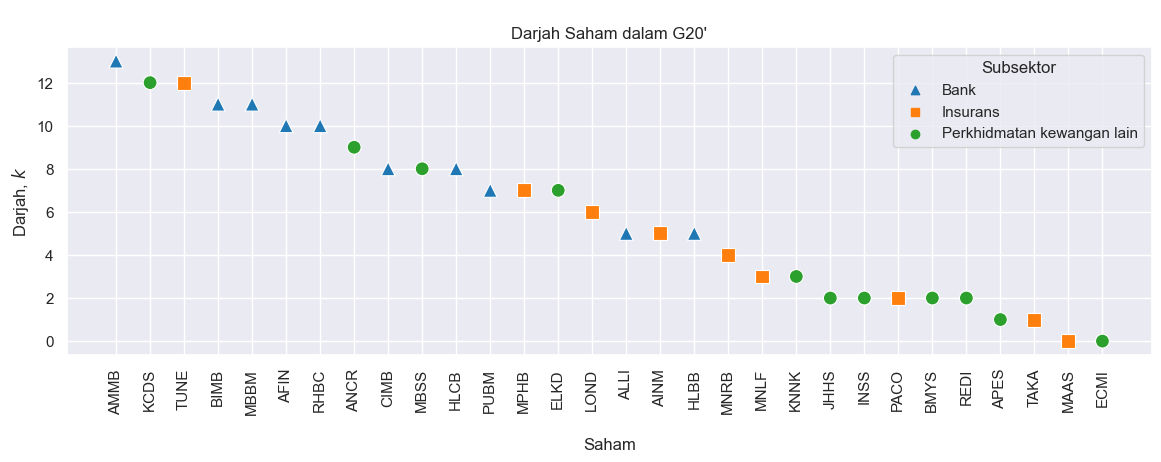

In [30]:
sns.set_theme()
degree_sorted = att.sort_values(by='degree', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}
# Define a consistent color palette for the subsectors
palette = {
    'Bank': '#1f77b4',
    'Insurans': '#ff7f0e',
    'Perkhidmatan kewangan lain': '#2ca02c'
}

# Define the order of the subsectors in the legend
hue_order = ['Bank', 'Insurans', 'Perkhidmatan kewangan lain']

# Map the marker shapes to the subsectors
degree_sorted['Marker'] = degree_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=degree_sorted,
    x='stock',
    y='degree',
    hue='subsector',# Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title("\nDarjah Saham dalam G20'")
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Darjah, $k$')

# Show legend
plt.legend(title='Subsektor')

plt.savefig('Darjah_2020_prime.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


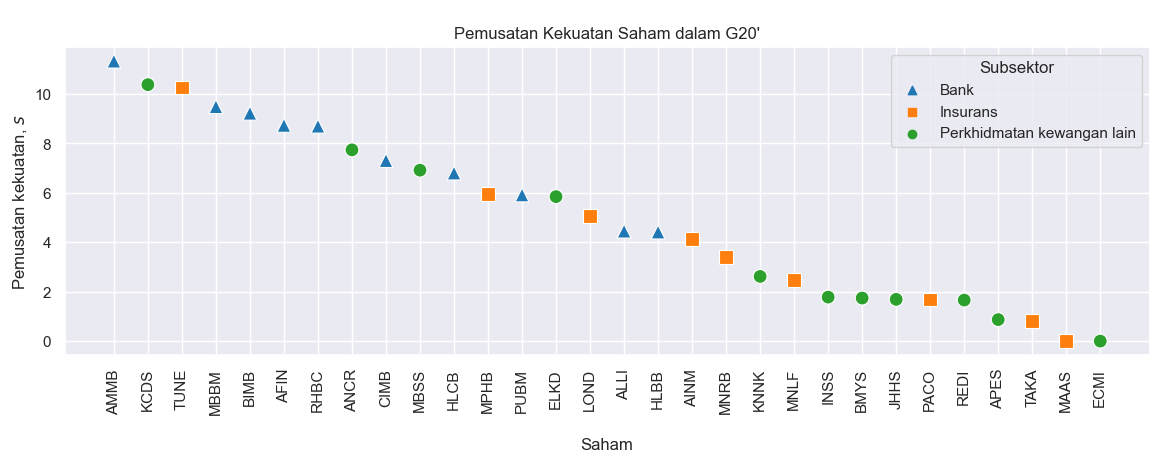

In [31]:
ndegree_sorted = att.sort_values(by='ndegree', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
ndegree_sorted['Marker'] = ndegree_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=ndegree_sorted,
    x='stock',
    y='ndegree',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title("\nPemusatan Kekuatan Saham dalam G20'")
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan kekuatan, $s$')

# Show legend
plt.legend(title='Subsektor')

plt.savefig('Darjah_berpemberat_2020_prime.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


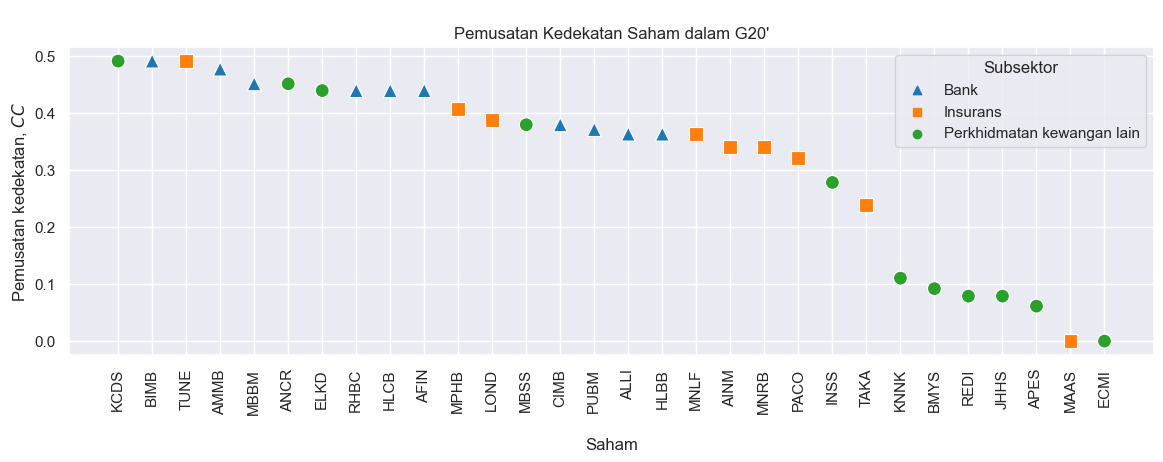

In [32]:
closeness_sorted = att.sort_values(by='closeness', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
closeness_sorted['Marker'] = closeness_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=closeness_sorted,
    x='stock',
    y='closeness',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title("\nPemusatan Kedekatan Saham dalam G20'")
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan kedekatan, $CC$')

# Show legend
plt.legend(title='Subsektor')

plt.savefig('Pemusatan_Kedekatan_2020_prime.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


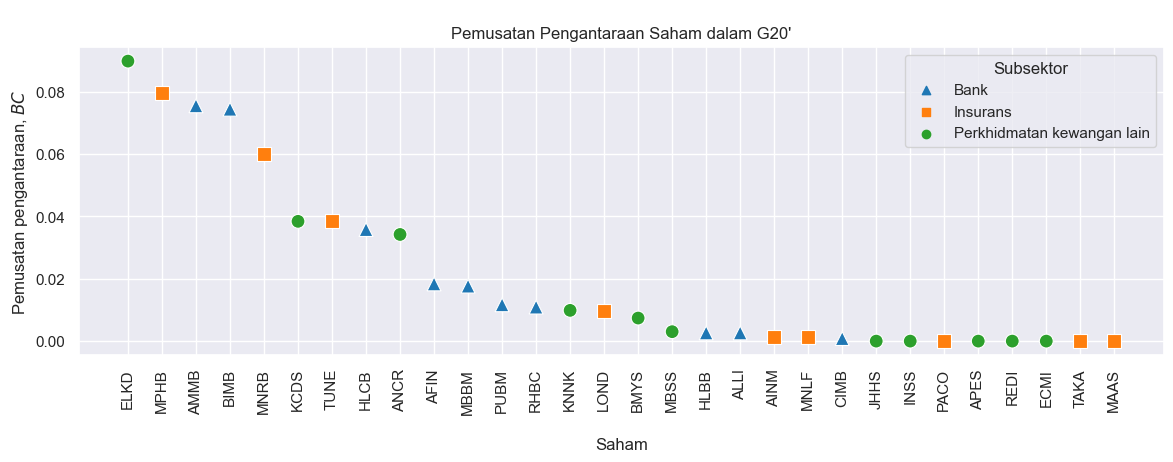

In [33]:
betweenness_sorted = att.sort_values(by='betweenness', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
betweenness_sorted['Marker'] = betweenness_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=betweenness_sorted,
    x='stock',
    y='betweenness',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title("\nPemusatan Pengantaraan Saham dalam G20'")
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan pengantaraan, $BC$')

# Show legend
plt.legend(title='Subsektor')

plt.savefig('Pemusatan_Pengantaraan_2020_prime.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


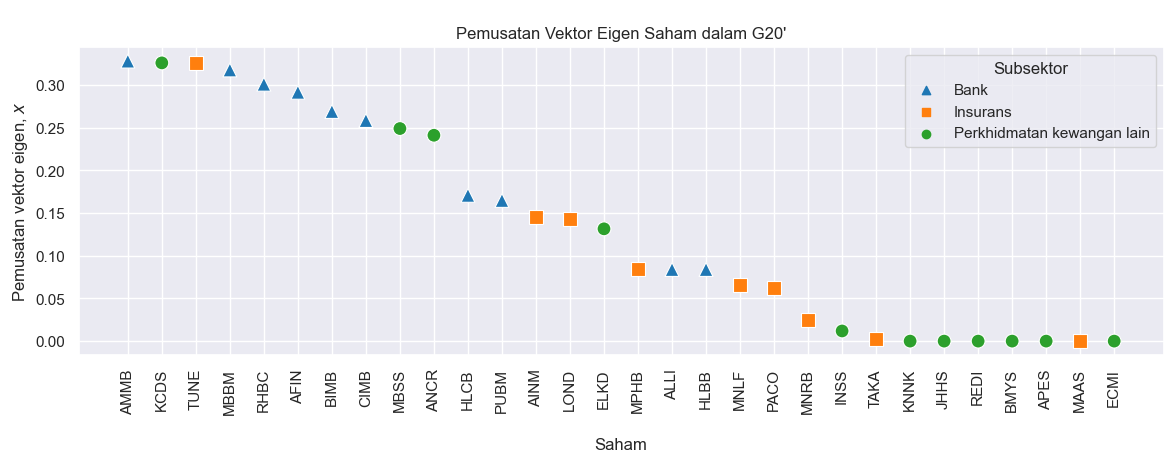

In [34]:
eigenvector_sorted = att.sort_values(by='eigenvector', ascending=False)

# Define marker shapes for each subsector
marker_shapes = {
    'Bank': '^',     # triangle up
    'Insurans': 's', # square
    'Perkhidmatan kewangan lain': 'o' # circle
}

# Map the marker shapes to the subsectors
eigenvector_sorted['Marker'] = eigenvector_sorted['subsector'].map(marker_shapes)

# Create the scatter plot
plt.figure(figsize=(14, 4))

sns.scatterplot(
    data=eigenvector_sorted,
    x='stock',
    y='eigenvector',
    hue='subsector',  # Color by subsector
    palette=palette,  # Use the consistent color palette
    hue_order=hue_order,  # Fix the order of the legend
    style='subsector',   # Different markers by subsector
    markers=marker_shapes,  # Pass the marker shapes
    s=100  # Size of the markers
)

plt.title("\nPemusatan Vektor Eigen Saham dalam G20'")
plt.xlabel('\nSaham')
plt.xticks(rotation=90)
plt.ylabel(r'Pemusatan vektor eigen, $x$')

# Show legend
plt.legend(title='Subsektor')

plt.savefig('Pemusatan_Vektoreigen_2020_prime.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


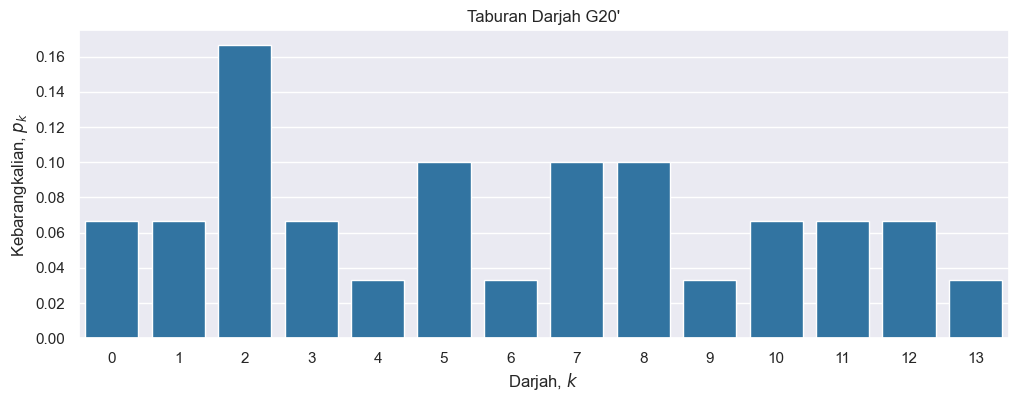

In [35]:
#sns.set_style("white")
# Calculate the degree for each node
degrees = pd.DataFrame(Gx.degree(), columns=['Node', 'Degree'])

# Calculate the degree distribution
degree_counts = degrees['Degree'].value_counts().sort_index()
total_nodes = len(degrees)

# Calculate the probability
degree_prob = degree_counts / total_nodes

# Plotting
plt.figure(figsize=(12, 4))
sns.barplot(x=degree_prob.index, y=degree_prob.values, color='#1f77b4')
plt.title("Taburan Darjah G20'")
plt.xlabel(r'Darjah, $k$')
plt.ylabel(r'Kebarangkalian, $p_k$')
plt.savefig('Taburan_darjah_2020_prime.jpg',dpi=500,bbox_inches = 'tight')
plt.show()


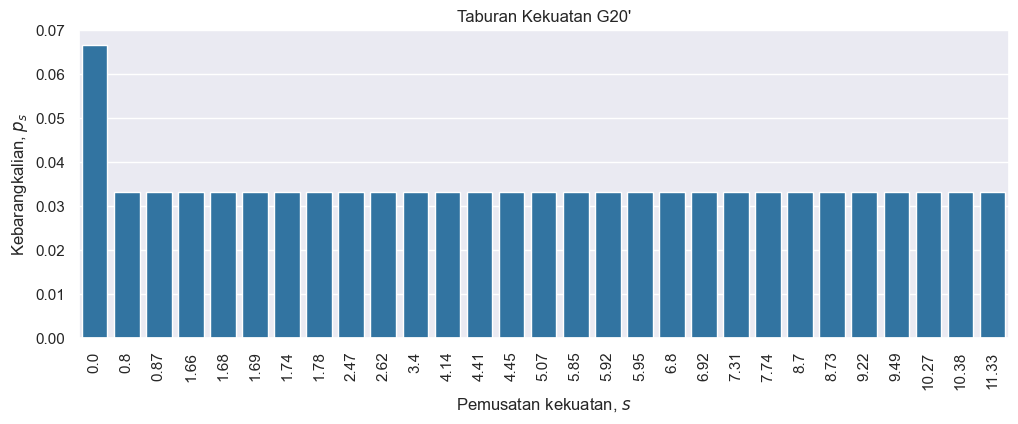

In [36]:
#sns.set_style("white")
# Calculate the degree for each node
degrees = pd.DataFrame(Gx.degree(weight='weight'), columns=['Node', 'Degree'])

# Round the weighted degrees to two decimal places
degrees['Degree'] = degrees['Degree'].round(2)

# Calculate the degree distribution
degree_counts = degrees['Degree'].value_counts().sort_index()
total_nodes = len(degrees)

# Calculate the probability
degree_prob = degree_counts / total_nodes

# Plotting
plt.figure(figsize=(12, 4))
sns.barplot(x=degree_prob.index, y=degree_prob.values, color='#1f77b4')
plt.title("Taburan Kekuatan G20'")
plt.xlabel(r'Pemusatan kekuatan, $s$')
plt.ylabel(r'Kebarangkalian, $p_s$')
# Rotate x-axis labels and format to two decimal points
plt.xticks(rotation=90)
#plt.gca().set_xticklabels([f'{x:.2f}' for x in degree_prob.index])

plt.savefig('Taburan_darjah_berpemberat_2020_prime.jpg',dpi=500,bbox_inches = 'tight')

plt.show()


In [37]:
# Calculate the sum of weighted degrees
total_weighted_degree = sum(ndegree_dict.values())

# Calculate the average weighted degree
average_weighted_degree = total_weighted_degree / len(Gx)

print("Average weighted degree:", average_weighted_degree)

Average weighted degree: 5.046118923083935


In [38]:
xy_label = pd.read_csv('Stock_label.csv')
xy_label.head()

,Id,Subsector
0,AFIN,Banking
1,AINM,Insurance
2,ALLI,Banking
3,AMMB,Banking
4,ANCR,Other Financials


In [39]:
#color_replacements = {"Banking": "red", "Insurance": "blue", "Other Financials": "green"}
#xy_label["color"] = xy_label["Subsector"].replace(color_replacements)
shape_emoji = {
    "Other Financials": "●",
    "Insurance": "■",
    "Banking": "▲",
    # Add more mappings for other shapes
}
xy_label["shape"] = xy_label["Subsector"].replace(shape_emoji)

xy_label.head()

,Id,Subsector,shape
0,AFIN,Banking,▲
1,AINM,Insurance,■
2,ALLI,Banking,▲
3,AMMB,Banking,▲
4,ANCR,Other Financials,●


In [40]:
xy_label["label"] = xy_label["Id"].str.cat(xy_label["shape"], sep=" ")
#xy_label["label"] = xy_label["Id"].str.cat(xy_label["shape"], sep=" - ")


xy_label.head()

,Id,Subsector,shape,label
0,AFIN,Banking,▲,AFIN ▲
1,AINM,Insurance,■,AINM ■
2,ALLI,Banking,▲,ALLI ▲
3,AMMB,Banking,▲,AMMB ▲
4,ANCR,Other Financials,●,ANCR ●


Text(0.5, 1.0, 'Correlogram correlation between stocks during COVID-19')

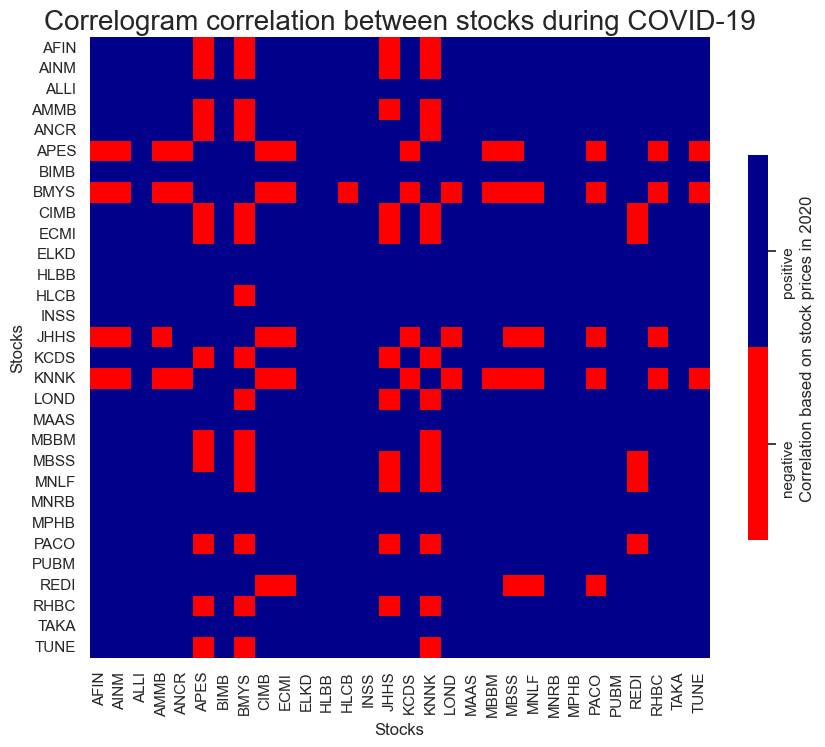

In [41]:
fig = plt.figure(figsize=(10, 10))
#df_heatmap = cor_matrix.pivot("Var1", "Var2", "Freq")

#sequential_colors = sns.color_palette("bright", 10)
# define the colors
cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])

# create a normalize object the describes the limits of
# each color
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

ax=sns.heatmap(cor_matrix,xticklabels=1, yticklabels=1, cmap= cmap, norm=norm, square=True,
           cbar_kws={"shrink": .5,'label': 'Correlation based on stock prices in 2020'})
plt.xlabel("Stocks")
plt.ylabel("Stocks")
# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.5,0.5])
colorbar.set_ticklabels(['negative', 'positive'], rotation=90)
plt.title(label="Correlogram correlation between stocks during COVID-19",fontsize=20,loc="center")

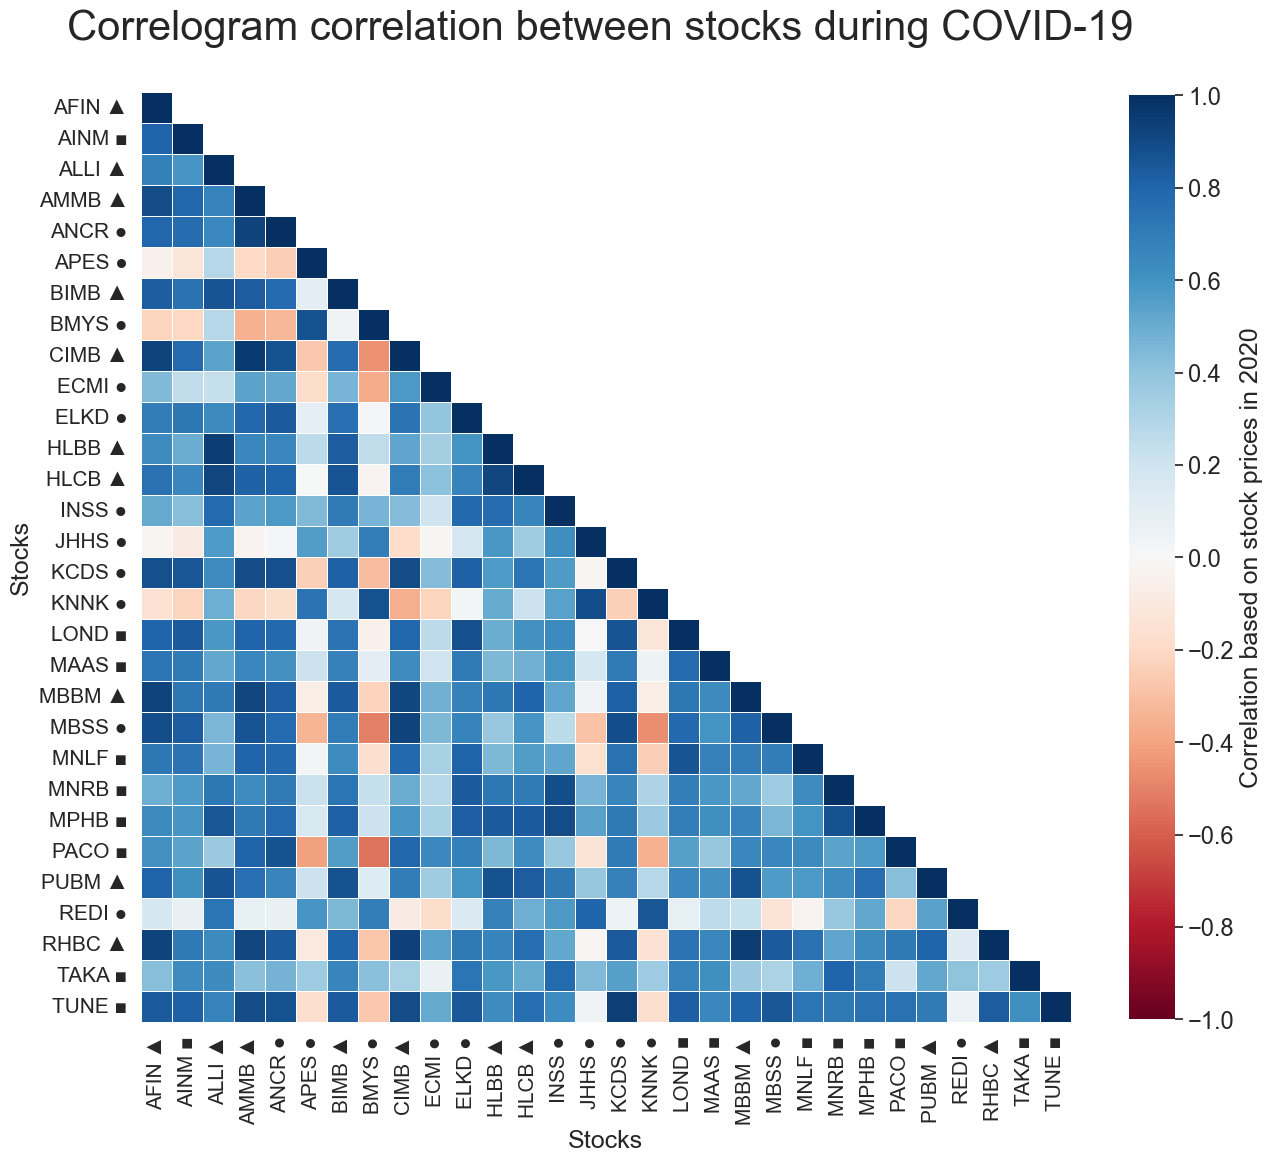

In [42]:
# Create a heatmap using Seaborn
sns.set()
#sns.set_theme(style="white")
sns.set_style("white")

cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


corr_df = cor_matrix.where(np.tril(np.ones(cor_matrix.shape)).astype(np.bool))

#mask = np.zeros_like(cor_matrix, dtype=np.bool_)
#mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 15))

ax = sns.heatmap(corr_df, xticklabels=1, yticklabels=1, cmap="RdBu", linewidths=.5, center=0,
                 square=True,vmin = -1.0, vmax=1.0,cbar_kws={"shrink": .8,
                                                             'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
                                                             'label': 'Correlation based on stock prices in 2020'})

g = plt.gca()


g.set_xticklabels(xy_label["label"])
g.set_yticklabels(xy_label["label"])

ax.figure.axes[-1].yaxis.label.set_size(18)
ax.figure.axes[-1].tick_params(labelsize=17)

plt.xlabel("Stocks",fontsize=18)
plt.ylabel("Stocks",fontsize=18)
plt.title(label="Correlogram correlation between stocks during COVID-19 \n",fontsize=30,loc="center")
plt.xticks(fontsize=15, rotation=90)  # Adjust rotation as needed
plt.yticks(fontsize=15)  # Adjust size for y-ticks
plt.savefig('Figure 2(b).jpg',dpi=500,bbox_inches = 'tight')
plt.show()

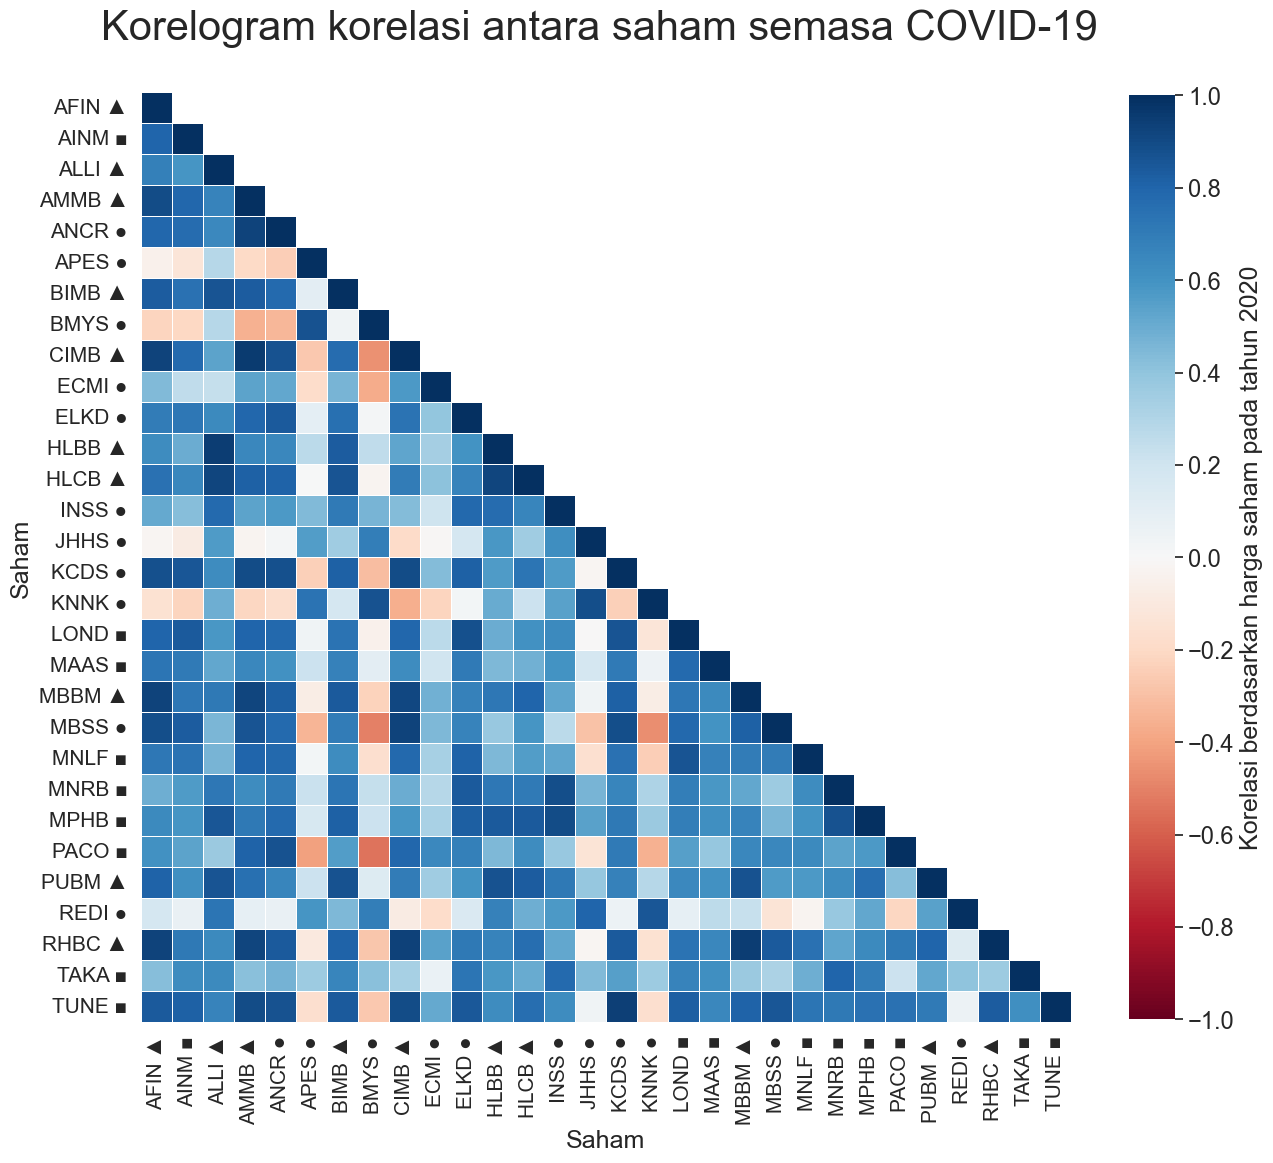

In [43]:
# Create a heatmap using Seaborn
sns.set()
#sns.set_theme(style="white")
sns.set_style("white")

cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


corr_df = cor_matrix.where(np.tril(np.ones(cor_matrix.shape)).astype(np.bool))

#mask = np.zeros_like(cor_matrix, dtype=np.bool_)
#mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 15))

ax = sns.heatmap(corr_df, xticklabels=1, yticklabels=1, cmap="RdBu", linewidths=.5, center=0,
                 square=True,vmin = -1.0, vmax=1.0,cbar_kws={"shrink": .8,
                                                             'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
                                                             'label': 'Korelasi berdasarkan harga saham pada tahun 2020'})

g = plt.gca()


g.set_xticklabels(xy_label["label"])
g.set_yticklabels(xy_label["label"])

ax.figure.axes[-1].yaxis.label.set_size(18)
ax.figure.axes[-1].tick_params(labelsize=17)

plt.xlabel("Saham",fontsize=18)
plt.ylabel("Saham",fontsize=18)
plt.title(label="Korelogram korelasi antara saham semasa COVID-19 \n",fontsize=30,loc="center")
plt.xticks(fontsize=15, rotation=90)  # Adjust rotation as needed
plt.yticks(fontsize=15)  # Adjust size for y-ticks
plt.savefig('Figure 5.2.jpg',dpi=500,bbox_inches = 'tight')
plt.show()

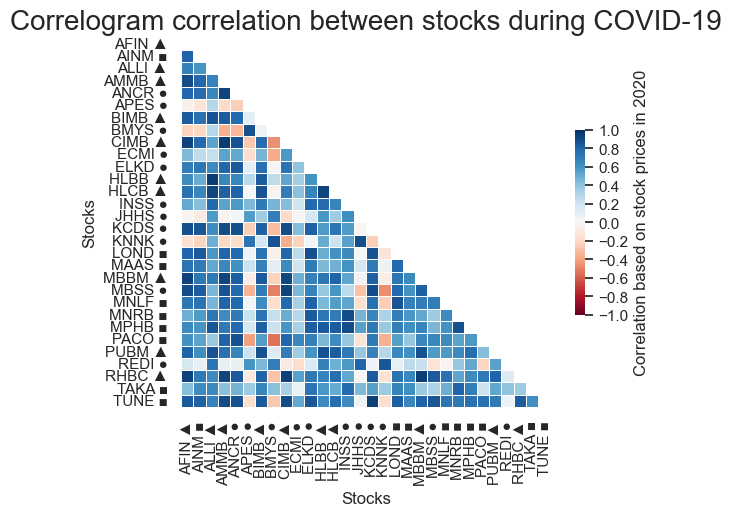

In [44]:
# Create a heatmap using Seaborn
sns.set()
#sns.set_theme(style="white")
sns.set_style("white")

cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

mask = np.zeros_like(cor_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(cor_matrix, mask=mask, xticklabels=1, yticklabels=1, cmap="RdBu", linewidths=.5, center=0,
                 square=True,vmin = -1.0, vmax=1.0,cbar_kws={"shrink": .5,
                                                             'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
                                                             'label': 'Correlation based on stock prices in 2020'})

g = plt.gca()


g.set_xticklabels(xy_label["label"])
g.set_yticklabels(xy_label["label"])
    
plt.xlabel("Stocks")
plt.ylabel("Stocks")
plt.title(label="Correlogram correlation between stocks during COVID-19",fontsize=20,loc="center")
plt.show()

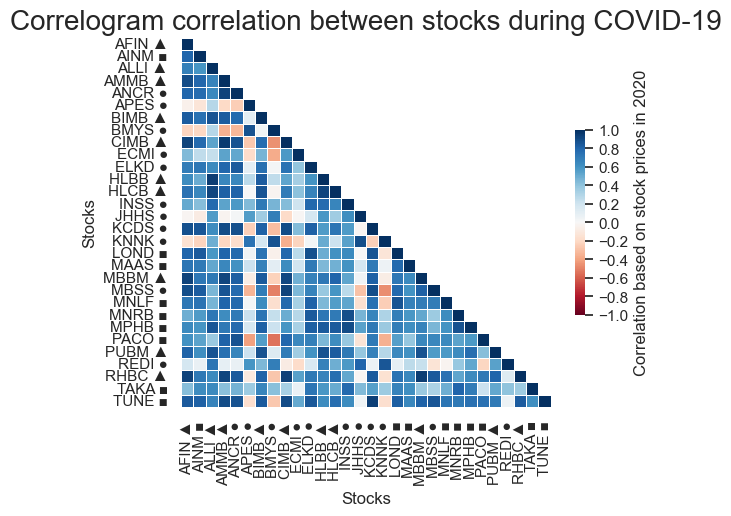

In [45]:
# Create a heatmap using Seaborn
sns.set()
#sns.set_theme(style="white")
sns.set_style("white")

cmap = matplotlib.colors.ListedColormap(['red', '#00008b'])
bounds = [-1., 0., 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


corr_df = cor_matrix.where(np.tril(np.ones(cor_matrix.shape)).astype(np.bool))

#mask = np.zeros_like(cor_matrix, dtype=np.bool_)
#mask[np.triu_indices_from(mask)] = True


ax = sns.heatmap(corr_df, xticklabels=1, yticklabels=1, cmap="RdBu", linewidths=.5, center=0,
                 square=True,vmin = -1.0, vmax=1.0,cbar_kws={"shrink": .5,
                                                             'ticks': [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
                                                             'label': 'Correlation based on stock prices in 2020'})

g = plt.gca()


g.set_xticklabels(xy_label["label"])
g.set_yticklabels(xy_label["label"])
    
plt.xlabel("Stocks")
plt.ylabel("Stocks")
plt.title(label="Correlogram correlation between stocks during COVID-19",fontsize=20,loc="center")
plt.show()

In [46]:
nx.write_gexf(Gx, 'G_2020_prime.gexf')# displays the graph without axis